# The thinking behind this code
I'd like to visualize the Reaction Wheel RPM data (the fifth of five datasets in my study) and then detect point outliers in it using simple statistics. Specifically, I'll call points outliers if they lie outside some number of standard deviations away from either the mean or a rolling mean with a fixed window. I'll explore the different results given by each mean, and how adjusting the number of standard deviations or the window's size affects the results.


In [1]:
# Standard modules
import datetime
import progressbar
import pandas as pd
import numpy as np
from matplotlib import pyplot
from pandas import datetime
from pandas import read_csv

## First thing's first: load the Reaction Wheel RPM data into a pandas Series

count    984911.000000
mean        217.368661
std         489.378793
min        -606.457725
25%           0.000000
50%           0.000000
75%           0.000000
max        1897.899717
Name: 1266.5271993532774, dtype: float64


2009-05-22 22:30:00
2009-05-22 22:35:00    1267.382818
2009-05-22 22:40:00    1267.260905
2009-05-22 22:45:00    1267.305787
2009-05-22 22:50:00    1267.859010
2009-05-22 22:55:00    1267.739962
Name: 1266.5271993532774, dtype: float64


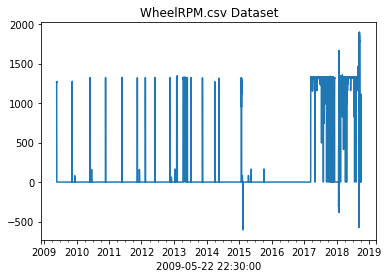

In [2]:
def parser(x):
    new_time = ''.join(x.split('.')[0])  # remove microseconds
    return datetime.strptime(new_time, '%Y-%m-%d %H:%M:%S') 


# Load the dataset
dataset_path = 'Data/WheelRPM.csv'
time_series = read_csv(dataset_path, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

print(time_series.describe())
print('\n')
print(time_series.head())
time_series.plot(title=dataset_path.split('/')[-1] + ' Dataset')  # plots the data
pyplot.show()    


## Next, let's see what 2 std's from the dataset's mean gives us

In [3]:
def detect_anomalies_with_mean(ts, num_stds, verbose, var_name='Value'):
    # Gather statistics in preparation for outlier detection
    mean = float(ts.values.mean())
    mean_line = pd.Series(([mean] * len(ts)), index=ts.index)
    std = float(ts.values.std(ddof=0))
    X = ts.values
    outliers = pd.Series()
    time_series_with_outliers = pd.DataFrame({var_name: ts})
    time_series_with_outliers['Outlier'] = 'False'

    if verbose:
        pyplot.plot(ts, color='blue', label='Time Series')
        pyplot.plot(mean_line, color='black', label='Time Series Mean')
        pyplot.legend(loc='best')
        pyplot.title('Time Series & Mean')
        pyplot.show()

    # Label outliers using standard deviation
    for t in range(len(X)):
        obs = X[t]
        if abs(mean-obs) > std*num_stds:
            time_series_with_outliers.at[ts.index[t], 'Outlier'] = 'True'
            outlier = pd.Series(obs, index=[ts.index[t]])
            outliers = outliers.append(outlier)

    return time_series_with_outliers, outliers


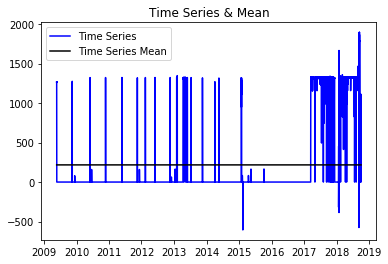


Detected Outliers: 157646



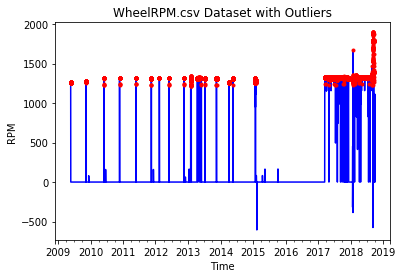

In [4]:
time_series_with_outliers, outliers = detect_anomalies_with_mean(time_series, 
                                                                 num_stds=2, verbose=True,
                                                                 var_name='RPM')

# Plot the outliers
time_series.plot(color='blue', title=dataset_path.split('/')[-1] + ' Dataset with Outliers')
pyplot.xlabel('Time')
pyplot.ylabel('RPM')
if len(outliers) > 0:
    print('\nDetected Outliers: ' + str(len(outliers)) + "\n")
    outliers.plot(color='red', style='.')
pyplot.show()

## As expected, every point that lies far enough above the mean line has now been labeled an outlier.

If we wanted to detect all the spikes in the data, this didn't do a bad job. But this data seems to flucuate regularly between 0 and ~1250, so those spikes are probably normal, not outliers. And should the negative values be outliers? We could adjust the threshold between normal and outlier by changing the number of standard deviations used. A larger number will detect fewer outliers, in theory, while a smaller number will detect more of them. Raising the number of standard deviations from 2 to 3 in this case will simply redefine "far enough above" to a higher value, and thus only detect the most extreme points:


Detected Outliers: 811



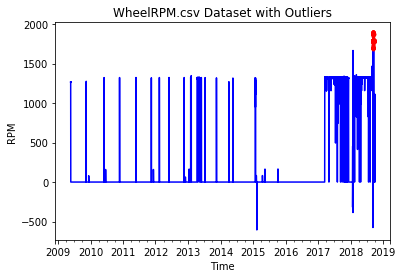

In [7]:
time_series_with_outliers, outliers = detect_anomalies_with_mean(time_series, 
                                                                 num_stds=3, verbose=False,
                                                                 var_name='RPM')

# Plot the outliers
time_series.plot(color='blue', title=dataset_path.split('/')[-1] + ' Dataset with Outliers')
pyplot.xlabel('Time')
pyplot.ylabel('RPM')
if len(outliers) > 0:
    print('\nDetected Outliers: ' + str(len(outliers)) + "\n")
    outliers.plot(color='red', style='.')
pyplot.show()

## Next, let's try a rolling mean with a window of 1000 samples

In [8]:
def detect_anomalies_with_rolling_mean(ts, num_stds, window, verbose, var_name='Value'):
    if window <= 0:
        raise ValueError('\'window\' must be given a value greater than 0 when using rolling mean.')
    else:
        # Gather statistics in preparation for outlier detection
        rolling_mean = ts.rolling(window=window, center=False).mean()
        first_window_mean = ts.iloc[:window].mean()
        for i in range(window):  # fill first 'window' samples with mean of those samples
            rolling_mean[i] = first_window_mean
        std = float(ts.values.std(ddof=0))
        X = ts.values
        outliers = pd.Series()
        time_series_with_outliers = pd.DataFrame({var_name: ts})
        time_series_with_outliers['Outlier'] = 'False'

        if verbose:
            pyplot.plot(ts, color='blue', label='Time Series')
            pyplot.plot(rolling_mean, color='black', label='Rolling Mean')
            pyplot.legend(loc='best')
            pyplot.title('Time Series & Rolling Mean')
            pyplot.show()

        # Label outliers using standard deviation
        for t in range(len(X)):
            obs = X[t]
            y = rolling_mean[t]
            if abs(y-obs) > std*num_stds:
                time_series_with_outliers.at[ts.index[t], 'Outlier'] = 'True'
                outlier = pd.Series(obs, index=[ts.index[t]])
                outliers = outliers.append(outlier)

        return time_series_with_outliers, outliers


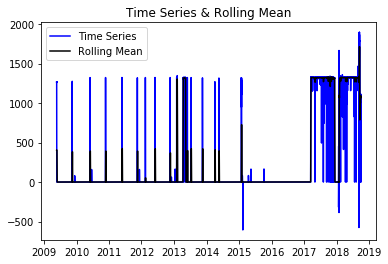


Detected Outliers: 5809



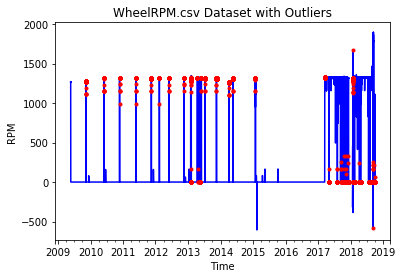

In [9]:
time_series_with_outliers, outliers = detect_anomalies_with_rolling_mean(time_series, 
                                                                         num_stds=2, 
                                                                         window=1000, 
                                                                         verbose=True)

# Plot the outliers
time_series.plot(color='blue', title=dataset_path.split('/')[-1] + ' Dataset with Outliers')
pyplot.xlabel('Time')
pyplot.ylabel('RPM')
if len(outliers) > 0:
    print('\nDetected Outliers: ' + str(len(outliers)) + "\n")
    outliers.plot(color='red', style='.')
pyplot.show()

## Here we see how a rolling mean can be more expressive than a flat mean. 

The rolling mean fits the data better than the flat mean. Some spikes in the data are now being considered normal. Selecting a useful window size is critical here. One that's too large starts to look like the flat mean, and too small overfits the data. (A window of the dataset's length will be the flat mean, and a window of 1 will be the original curve.) Let's see what overfitting does by changing the window from 1000 to 5:

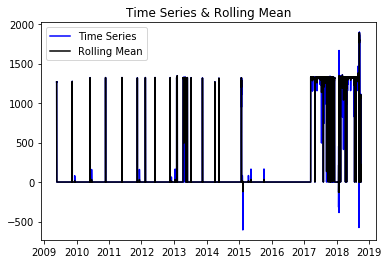


Detected Outliers: 32



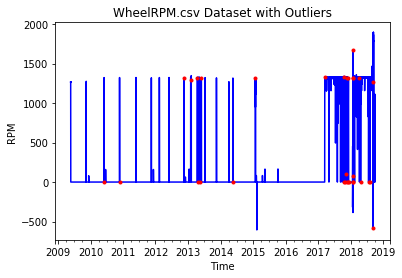

In [11]:
time_series_with_outliers, outliers = detect_anomalies_with_rolling_mean(time_series, 
                                                                         num_stds=2, 
                                                                         window=5, 
                                                                         verbose=True)

# Plot the outliers
time_series.plot(color='blue', title=dataset_path.split('/')[-1] + ' Dataset with Outliers')
pyplot.xlabel('Time')
pyplot.ylabel('RPM')
if len(outliers) > 0:
    print('\nDetected Outliers: ' + str(len(outliers)) + "\n")
    outliers.plot(color='red', style='.')
pyplot.show()

## There are now significantly fewer outliers labeled, because the rolling mean is practically the original curve. 
This has now detected only a handful of outliers at spikes that seemingly happen closer together. It has also labeled some ~0 values as outliers due to the mean itself spiking. This could be good or bad, depending on what you wanted to find (i.e., what you want to consider an outlier). The statistical methods explored here are simplistic, but they could be useful depending on what you want from them. It's important to consider them before trying more complicated methods. If this doesn't cut it, diagnose what's wrong/missing and then maybe try something more advanced.